In [2]:
import math
import pypoman
import scipy as sp
import matplotlib.pyplot as plt
from scipy.stats import bernoulli, uniform, chi2
import numpy as np
from scipy.stats.mstats import gmean
from numpy.testing import assert_allclose
from iteround import saferound
from utils import sprt_mart, alpha_mart, shrink_trunc, stratum_selector, \
    multinomial_selector, get_global_pvalue, simulate_audits, round_robin, ucb_selector, maximize_bsmg
np.random.seed(123456789)

In [2]:
#to project onto polytope \mathcal{C}
#need the packages 'qpsolvers' and 'quadprog' as well as the dev version of 'pypoman'
#run these:
#pip install --upgrade --force-reinstall git+https://github.com/stephane-caron/pypoman
#pip install qpsolvers
#pip install quadprog
import qpsolvers
print(qpsolvers.available_solvers)

['cvxopt', 'quadprog']


## 2-stratum comparison audits with $\eta$-adaptive allocation

In [23]:
N = np.array([100, 100]) #stratum sizes
w = N / np.sum(N)
mu = 0.6 #global true mean
stratum_gaps = [0, .2, .4, .6, .8] #difference in true means
results_rr = []
results_ls = []
results_ms = []
for i in np.arange(len(stratum_gaps)):
    mu_1 = mu - w[0] * stratum_gaps[i]
    mu_0 = mu_1 + stratum_gaps[i]
    totals = np.array(saferound([mu_0 * N[0], (1-mu_0) * N[0], mu_1 * N[1], (1-mu_1) * N[1]], 0)).astype(int)
    hand_tally = np.concatenate((np.ones(totals[0]), np.zeros(totals[1]), np.ones(totals[2]), np.zeros(totals[3])))
    reported_tally = hand_tally
    omega = reported_tally - hand_tally
    stratum_indicator = np.concatenate((np.ones(N[0]), 2*np.ones(N[1])))
    u_A = np.ones(2)
    A_c = [np.mean(reported_tally[stratum_indicator == 1]), np.mean(reported_tally[stratum_indicator == 2])]
    print(A_c)
    strata = [u_A[0] - omega[stratum_indicator == 1], u_A[1] - omega[stratum_indicator == 2]]
    results_rr.append(get_global_pvalue(strata = strata, u_A = u_A, A_c = A_c, rule = round_robin))
    results_ls.append(get_global_pvalue(strata = strata, u_A = u_A, A_c = A_c, rule = ucb_selector))
    results_ms.append(get_global_pvalue(strata = strata, u_A = u_A, A_c = A_c, rule = multinomial_selector))

[0.6, 0.6]
[0.7, 0.5]
[0.8, 0.4]
[0.9, 0.3]
[1.0, 0.2]


In [24]:
for i in np.arange(len(stratum_gaps)):
    print("\n")
    print("round robin with stratum gap of " + str(stratum_gaps[i]) + " had stopping time:" + str(np.min(np.where(results_rr[i][0] < .05))))
    print("lower-sided test with stratum gap of " + str(stratum_gaps[i]) + " had stopping time:" + str(np.min(np.where(results_ls[i][0] < .05))))
    print("martingale-proportional probability with stratum gap of " + str(stratum_gaps[i]) + " had stopping time:" + str(np.min(np.where(results_ms[i][0] < .05))))
    



round robin with stratum gap of 0 had stopping time:27
lower-sided test with stratum gap of 0 had stopping time:40
martingale-proportional probability with stratum gap of 0 had stopping time:28


round robin with stratum gap of 0.2 had stopping time:27
lower-sided test with stratum gap of 0.2 had stopping time:38
martingale-proportional probability with stratum gap of 0.2 had stopping time:29


round robin with stratum gap of 0.4 had stopping time:27
lower-sided test with stratum gap of 0.4 had stopping time:44
martingale-proportional probability with stratum gap of 0.4 had stopping time:29


round robin with stratum gap of 0.6 had stopping time:27
lower-sided test with stratum gap of 0.6 had stopping time:44
martingale-proportional probability with stratum gap of 0.6 had stopping time:28


round robin with stratum gap of 0.8 had stopping time:27
lower-sided test with stratum gap of 0.8 had stopping time:38
martingale-proportional probability with stratum gap of 0.8 had stopping time

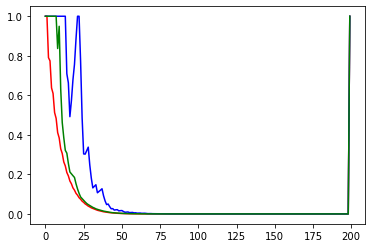

In [4]:
#plot P-values
#plt.subplots(2, len(stratum_gaps))
#very suprising that round robin is better than LSM...
plt.plot(results_rr[0][0], color = 'red')
plt.plot(results_ls[0][0], color = 'blue')
plt.plot(results_ms[0][0], color = 'green')
plt.show()

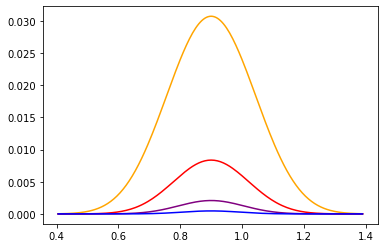

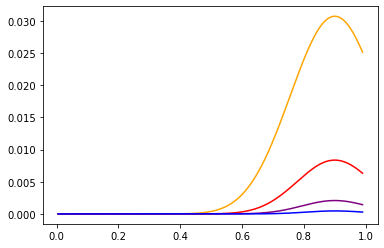

In [5]:
#plot P-values at various sample times as a function of null mean in stratum 1 and the stratum gap...
for i in [0,len(stratum_gaps)-1]:
    plt.plot(results_rr[i][4], 1/np.maximum(1,results_rr[i][3][30,:]), color = 'orange')
    plt.plot(results_rr[i][4], 1/np.maximum(1,results_rr[i][3][40,:]), color = 'red')
    plt.plot(results_rr[i][4], 1/np.maximum(1,results_rr[i][3][50,:]), color = 'purple')
    plt.plot(results_rr[i][4], 1/np.maximum(1,results_rr[i][3][60,:]), color = 'blue')
    plt.show()

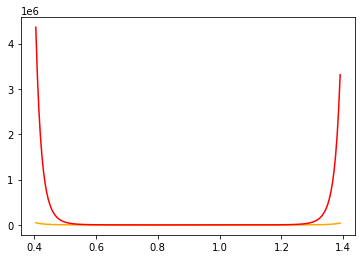

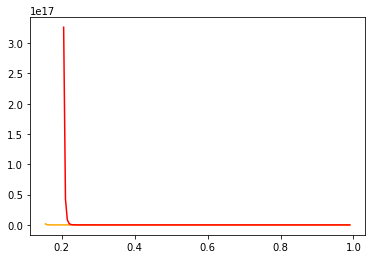

In [25]:
#plot martingales at various sample times as a function of null mean in stratum 1 and the stratum gap...
for i in [0,len(stratum_gaps)-1]:
    plt.plot(results_rr[i][4], results_rr[i][3][30,:], color = 'orange')
    plt.plot(results_rr[i][4], results_rr[i][3][40,:], color = 'red')

    plt.show()

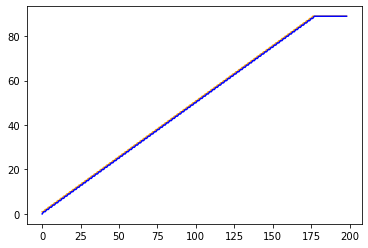

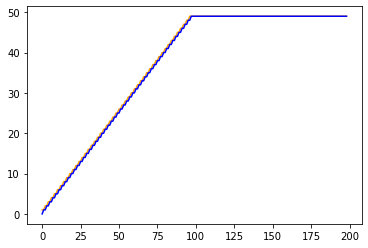

In [20]:
#cumulative stratum selections at each time for different populations: round robin
theta_1 = 0.5
null_index = np.where(results_rr[i][4] == theta_1)[0][0]
for i in [0,len(stratum_gaps)-1]:
    stratum_1_counter = np.cumsum(results_rr[i][5] == 0, 0)
    stratum_2_counter = np.cumsum(results_rr[i][5] == 1, 0)
    plt.plot(stratum_1_counter[:,null_index], color = 'orange')
    plt.plot(stratum_2_counter[:,null_index], color = 'blue')
    plt.show()

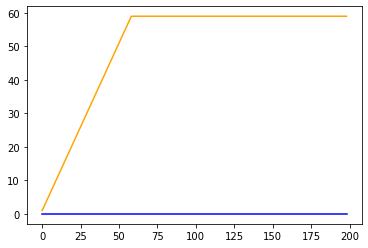

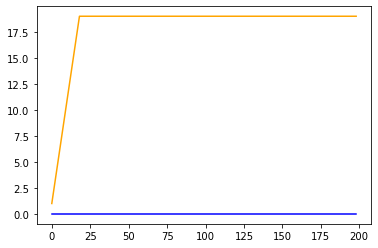

In [36]:
#cumulative stratum selections at each time for different populations: martingale-proportional probability
theta_1 = 0.2
null_index = np.argmin((results_rr[i][4] - theta_1)**2)
for i in [0,len(stratum_gaps)-1]:
    stratum_1_counter = np.cumsum(results_ms[i][5] == 0, 0)
    stratum_2_counter = np.cumsum(results_ms[i][5] == 1, 0)
    plt.plot(stratum_1_counter[:,null_index], color = 'orange')
    plt.plot(stratum_2_counter[:,null_index], color = 'blue')
    plt.show()

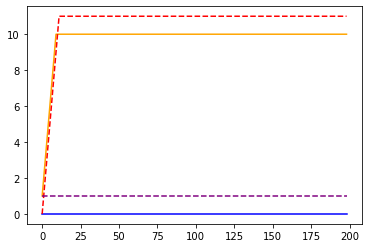

In [43]:
#nulls that are close tend to have similar stratum counters ?
null_index_1 = np.argmin((results_ms[0][4] - .5)**2)
null_index_2 = np.argmin((results_ms[0][4] - .51)**2)

stratum_1_counter = np.cumsum(results_ms[i][5] == 0, 0)
stratum_2_counter = np.cumsum(results_ms[i][5] == 1, 0)

plt.plot(stratum_1_counter[:,null_index_1], color = 'orange')
plt.plot(stratum_2_counter[:,null_index_1], color = 'blue')
plt.plot(stratum_1_counter[:,null_index_2], color = 'red', linestyle = '--')
plt.plot(stratum_2_counter[:,null_index_2], color = 'purple', linestyle = '--')
plt.show()

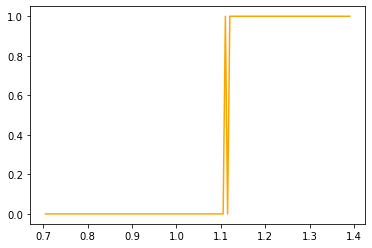

In [55]:
#for particular time(s), plot the stratum selections as a function of the null mean
times = [50]
colors = ['orange', 'red', 'purple', 'blue']
null_means = results_ms[0][4]
for t in np.arange(len(times)):
    plt.plot(null_means, results_ms[2][5][times[t],:], color = colors[t])
plt.show()

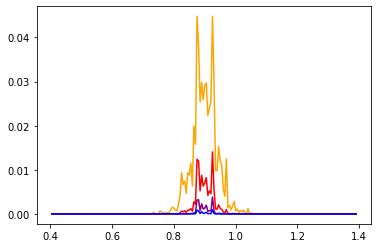

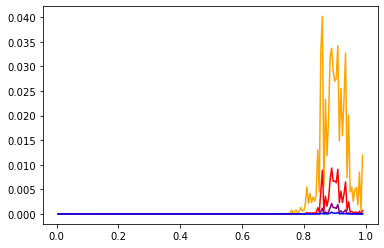

In [36]:
#plot P-values at various sample times as a function of null mean in stratum 1 and the stratum gap...
for i in [0,len(stratum_gaps)-1]:
    plt.plot(results_ms[i][4], 1/np.maximum(1,results_ms[i][3][30,:]), color = 'orange')
    plt.plot(results_ms[i][4], 1/np.maximum(1,results_ms[i][3][40,:]), color = 'red')
    plt.plot(results_ms[i][4], 1/np.maximum(1,results_ms[i][3][50,:]), color = 'purple')
    plt.plot(results_ms[i][4], 1/np.maximum(1,results_ms[i][3][60,:]), color = 'blue')
    plt.show()

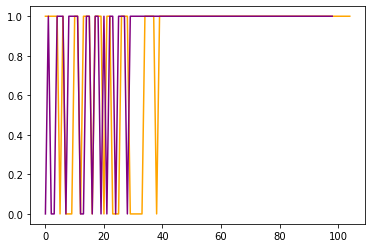

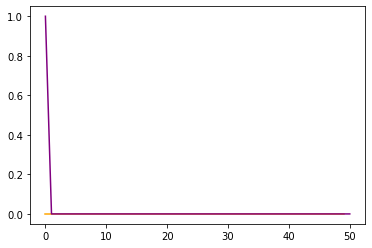

In [38]:
#plot stratum selections at each time for different null means
for i in [0,len(stratum_gaps)-1]:
    plt.plot(results_ms[i][5][:,100], color = 'orange')
    #plt.plot(results_ms[i][5][:,100], color = 'red')
    plt.plot(results_ms[i][5][:,101], color = 'purple')
    plt.show()

## Betting martingales with arbitrary $K$ by PGD

In [12]:
#TODO: how do we gaurantee that optimization has converged (Cauchy sequence?)? how do we set the step size (delta)?
#results = maximize_bsmg(samples = samples, lam = lam, N = N, theta = 1/2)
print("number of steps = " + str(results[0]) +
    "\nminimizing eta = " + str(np.round(results[1],2)) + 
      "\nlog-martingale = " +  str(results[2]) + 
      "\nP-value = " + str(results[3]))

number of steps = 1
minimizing eta = [0.47 0.47 0.57]
log-martingale = 2.479395292681576
P-value = 0.08379388104789877


In [13]:
#fixed lambda strategies
lam = [np.random.uniform(0,1,n[0]), np.random.uniform(0,1,n[1]), np.random.uniform(0,1,n[2])]

log_mart = lambda eta, k: np.sum(np.log(1 + lam[k] * (samples[k] - eta[k])))
global_log_mart = lambda eta: np.sum([log_mart(eta, k) for k in np.arange(K)])
mart = lambda eta, k: np.prod(1 + lam[k] * (samples[k] - eta[k]))
global_mart = lambda eta: np.prod([mart(eta, k) for k in np.arange(K)])

In [146]:
#adaptive lambda strategies
#agrapa from W-SR
def lam_agrapa(eta, x):
    S = np.insert(np.cumsum(x),0,0)[0:-1]  # 0, x_1, x_1+x_2, ...,
    j = np.arange(1,len(x)+1)  # 1, 2, 3, ..., len(x)
    mu_hat = S/j
    mj = [x[0]]                            # Welford's algorithm for running mean and running SD
    sdj = [0]
    for i, xj in enumerate(x[1:]):
        mj.append(mj[-1]+(xj-mj[-1])/(i+1))
        sdj.append(sdj[-1]+(xj-mj[-2])*(xj-mj[-1]))
    sdj = np.sqrt(sdj/j)
    sdj = np.insert(np.maximum(sdj,.1),0,1)[0:-1]
    lam_untrunc = (mu_hat - eta) / (sdj**2 + (mu_hat - eta)**2)
    lam_trunc = np.maximum(0, np.minimum(lam_untrunc, .75/eta))
    return lam_trunc

#simple truncation
def lam_trunc(eta, x):
    S = np.insert(np.cumsum(x),0,0)[0:-1]  # 0, x_1, x_1+x_2, ...,
    j = np.arange(1,len(x)+1)  # 1, 2, 3, ..., len(x)
    mu_hat = S/j
    lam_trunc = np.where(eta <= mu_hat, .75 / eta, 0)
    return lam_trunc

#this seems convex but not powerful for all alternatives
def lam_smooth(eta, x):
    lam = np.exp(- eta)
    return lam

#this *seems* both convex and powerful for all alternatives
def lam_smooth_predictable(eta, x):
    lag_mean = np.insert(np.cumsum(x),0,0)[0:-1] / np.arange(1,len(x)+1)
    lam = np.exp(lag_mean - eta)
    return lam


log_ada_mart = lambda eta, k: np.sum(np.log((1 + lam_smooth_predictable(eta[k], samples[k]) * (samples[k] - eta[k]))))
global_log_ada_mart = lambda eta: np.sum([log_ada_mart(eta, k) for k in np.arange(K)])
ada_mart = lambda eta, k: np.prod(1 + lam_predictable(eta[k], samples[k]) * (samples[k] - eta[k]))
global_ada_mart = lambda eta: np.prod([ada_mart(eta, k) for k in np.arange(K)])

In [155]:
N = np.array([1000, 1000, 1000])
n = [100, 100, 100]
w = N/np.sum(N)
K = 3

#samples = [0 * np.ones(n[0]), 0.7 * np.ones(n[1]), 0.9 * np.ones(n[2])]
samples = [np.random.normal(0.3, .05, n[0]), np.random.normal(0.5, .05, n[1]), np.random.normal(0.9, .05, n[2])]
np.mean(samples)

0.5670935129653379

19.8718727692594 0.25 0.44 0.81


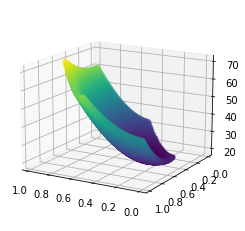

In [156]:
eta_grid = np.arange(0.01,.99,step=1e-2)
xs, ys, zs, objs = [], [], [], []
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

for x in eta_grid:
    for y in eta_grid:
        #z = 1/np.maximum(1,np.exp(global_log_mart(eta = np.array([x, y, 1-x-y]))))
        z = (1/2 - w[0]*x-w[1]*y)/w[2]
        if z > 1 or z < 0: continue
        obj = global_log_ada_mart(eta = np.array([x, y, z]))
        xs.append(x)
        ys.append(y)
        zs.append(z)
        objs.append(obj)
ax.scatter(xs, ys, objs, c = objs)

print(np.min(objs), xs[np.argmin(objs)], ys[np.argmin(objs)], zs[np.argmin(objs)])
ax.view_init(15, 120)
plt.show()

In [61]:
#print(global_log_mart(np.array([0.5, 0, 1])))
#print(global_log_mart(np.array([.5, .5, .5])))
t = 0.5
eta_1 = np.array([0.5,0.5,0.5])
eta_2 = np.array([0.6,0.5,0.4])

#not convex :P
print(t * global_log_mart(eta_1) + (1-t) * global_log_mart(eta_2))
print(global_log_mart(t * eta_1 + (1-t) * eta_2))

#original martingale
print(t * global_mart(eta_1) + (1-t) * global_mart(eta_2))
print(global_mart(t * eta_1 + (1-t) * eta_2))

-0.6257825545296356
-0.312597696959239
0.6430283681651799
0.7315441558157696


In [83]:
eta_1 = np.array([0.5])
eta_2 = np.array([0.55])
#this does seem convex...
print(t * mart(eta_1, 0) + (1-t) * mart(eta_2, 0))
print(mart(t * eta_1 + (1-t) * eta_2, 0))

0.5000015895633967
0.001855889647725837


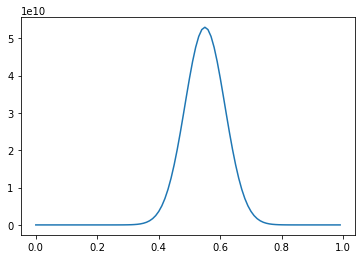

In [132]:
N = np.array([1000, 1000])
n = [500, 500]
w = N/np.sum(N)
K = 2
#plot the log-martingale surface as a function of eta?
samples = [0.6 * np.ones(n[0]), 0.5 * np.ones(n[1])]
#samples = [np.random.normal(0.6, .05, n[0]), np.random.normal(0.5, .05, n[1])]
lam = np.array([0.5, 0.5])

mart = lambda eta, k: np.prod(1 + lam[k] * (samples[k] - eta[k]))
global_mart = lambda eta: np.prod([mart(eta, k) for k in np.arange(K)])
eta_grid = np.arange(0,1,step=1e-2)

obj = []
for i in np.arange(len(eta_grid)):
    obj.append(global_mart(np.array([eta_grid[i], (1/2 - w[0]*eta_grid[i]) / w[1]])))
plt.plot(eta_grid, obj)

# Two-strata fixed $\lambda$

Suppose $K=2$, $N_1 = N_2$, $\lambda_{ik} = \lambda$, the two-strata are simply point masses at $x_1, x_2 \in [0,1]$, and $n_k = n$. Let $\eta_1 = \eta$ and $\eta_2 = 1 - \eta$. We have:
\begin{align}
M_t(\boldsymbol{\eta}) &= \prod_{k=1}^K \prod_{i=1}^{n_k} [1 + \lambda_{ik} (X_{ik} - \eta_k)] \\ 
&= \prod_{k=1}^2 (1 + \lambda (x_k - \eta_k))^n \\
&= [(1 + \lambda (x_1 - \eta)) (1 + \lambda (x_2 - (1 - \eta)))]^n\\
&= [1 + \lambda x_2 - \lambda - \lambda \eta + \lambda x_1 + \lambda^2 x_1 x_2 - \lambda^2 x_1 - \lambda^2 x_1 \eta_2 - \lambda \eta - \lambda^2 x_2 \eta + \lambda^2 \eta + \lambda^2 \eta^2]^n\\
&= [(1 + \lambda x_2 - \lambda + \lambda x_1 + \lambda^2 x_1 x_2 - \lambda^2 x_1) + (-2 \lambda - \lambda^2 x_1 -\lambda^2 x_2 + \lambda^2) \eta  + \lambda^2 \eta^2 ]^n\\
\end{align}

Assume that $M_t(\boldsymbol{\eta})$ is quasi-concave for any $\lambda_{ik}, x_{ik}, \eta_k \in [0,1]$ (this seems true but remains to be proven; note that log-concave functions are quasi-concave.). Then the minimum occurs on the boundary: $\eta = 1$ or $\eta = 0$. 



#### Example
WLOG assume that the minimum occurs when $\eta = 0$. Then as a function of $n$ we have:
\begin{align}
M_t(\boldsymbol{\eta}) &= (1 - \lambda + (\lambda - \lambda^2) x_1 + \lambda x_2 + \lambda^2 x_1 x_2)^n
\end{align}

Take $\lambda = 1$, then $M_t^* = (x_1 + x_1 x_2)^n$; this grows as a function of $n$ only if $x_1 + x_1 x_2 > 1$ while the global alternative is true as long as $x_1 + x_2 > 1$. Take, for example, $x_1 = 0.6$ and $x_2 = 0.5$ then the global alternative is true, but $0.6 + 0.5 * 0.6 = 0.9 < 1$, so the martingale shrinks as a function of $n$ and the $P$-value increases.  


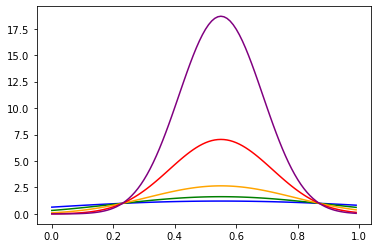

In [114]:
#for plotting when x_1 = x_2 = 0.5 and \lambda = 0.5
eta_grid = eta_grid = np.arange(0,1,step=1e-2)
#obj_val = lambda eta, n: (0.95 + 0.25*eta - 0.25*eta**2)**n

#case where alternative is true
obj_val = lambda eta, n: ((1 + 1 * (.6 - eta)) * (1 + 1 * (.5 - (1-eta))))**n
plt.plot(eta_grid, obj_val(eta = eta_grid, n = 2), color = 'blue')
plt.plot(eta_grid, obj_val(eta = eta_grid, n = 5), color = 'green')
plt.plot(eta_grid, obj_val(eta = eta_grid, n = 10), color = 'orange')
plt.plot(eta_grid, obj_val(eta = eta_grid, n = 20), color = 'red')
plt.plot(eta_grid, obj_val(eta = eta_grid, n = 30), color = 'purple')
plt.show()